<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/bagOfWords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

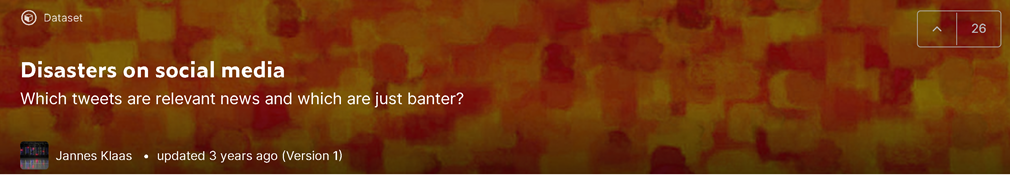

In [ ]:
# Last amended: 19th Sep, 2021
# Myfolder: /home/ashok/Documents/10.nlp_workshop/bagOfWords
# Ref: https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
#
#
#DataSource: 
#   Disasters on social media
#  	Contributors looked at over 10,000 tweets retrieved with
#  	a variety of searches like “ablaze”, “quarantine”, and
#  	“pandemonium”, then noted whether the tweet referred to
#  	a disaster event (as opposed to used in a joke or with 
#  	the word or a movie review or something non-disastrous). 
#
# Objective:
#		Build bag of words model
#		Build tf-idf model
#
#
#	$ ipython
#


In [ ]:
## 1.0 Call libraries
%reset -f
import pandas as pd
import numpy as np

# 1.1 Classes to build bag of words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 1.2 train/test split
from sklearn.model_selection import train_test_split

# 1.3 Modeling classes
from sklearn.linear_model import LogisticRegression

# 1.4 Accuracy metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# 1.5 Misc
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
##### 2.0 Read and Sanitize data  #####
#     2.1 Where is my data file?
#os.chdir("/home/ashok/Documents/10.nlp_workshop/word2vec")
# os.chdir("D:\\data\\OneDrive\\Documents\\seminar course\\tweets-disaster")
os.chdir("/content/gdrive/MyDrive/Colab_data_files/disaster_tweets")

In [ ]:

# 2.2 Let's inspect the data
#     See StackOverflow: https://stackoverflow.com/a/18172249
#     Default 'header' is 'infer'
questions = pd.read_csv("socialmedia_relevant_cols.csv.gz",
                        encoding="ISO-8859-1"      # 'utf-8' gives error, hence the choice
                        )


In [ ]:
# 2.3 Nevertheless we may assign column names
# questions.columns=['text', 'choose_one', 'class_label']

In [ ]:
# 2.4 Inspect the data now
questions.head()
questions.tail()
questions.describe()

In [ ]:
df = pd.DataFrame(["http://fsm.ac.in"], columns=["a"])
df.head()

,a
0,http://fsm.ac.in


In [ ]:
df["a"].str.replace(r"http\S+", "")

0    
Name: a, dtype: object

In [ ]:
# 2.5 Clean the data
#     Let's use a few regular expressions to clean up data,
#     and save it back to disk for future use
# Ref: http://www.regexlib.com/(X(1)A(5VYROh19ihtNP-JfoQjDSiymxutkQHoWK2wjkPydrzYhq5c450yDq5RxRfvQsrh09BHiCyJCNwIztpf_CsfLdb_1KDUgs1fy1BApFZ3xE8T_lQnsDlHhP1OEtO4T58M2x4_sJkRwe2gdtYRimfwin6FDQLaahvTmhUwWQ8sBhDg09H7kKKUevqzC8N1j4LNT0))/cheatsheet.htm?AspxAutoDetectCookieSupport=1
#     Experiment like this:
#
#          "@abc".replace(r"@", "at")
#
#          "http://fsm.ac.in".replace(r"http\S+", "")
def standardize_text(df, text_field):
    # 2.5.1 Matches http followed by one or more non-white-space characters
    #       ie. including all the alphabetical and numeric characters, punctuation, etc.
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
   	# 2.5.2 Matches http. Note the sequence of instructions
    df[text_field] = df[text_field].str.replace(r"http", "")
    # 2.5.3 Matches @ followed by one or more non-white-space characters
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    # 2.5.4 Matches any character not included within square brackets
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df



In [ ]:
df = pd.DataFrame(["http://fsm.ac.in"], columns=["a"])
df.head()

In [ ]:
df["a"].str.replace(r"http\S+", "")

In [ ]:
df = pd.DataFrame(["@http://fsm.ac.in"], columns=["a"])
df["a"].str.replace(r"@\S+", "")

0    
Name: a, dtype: object

In [ ]:

# 2.6 Apply function and clean now
clean_questions = standardize_text(questions, "text")


In [ ]:
# 2.7 Let's look at our class balance.
clean_questions.groupby("class_label").count()


In [ ]:
#########################
## Bag of Words Counts ##
#########################


In [ ]:
# 3. Function to fit/transform text
#    CountVectorizer class converts collection of text documents
#    to a matrix of token counts
def cv(data):
	# 3.1 Instantiate CountVectorizer object
    count_vectorizer = CountVectorizer()
    # 3.2 Fit and transform text 'data'
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer



In [ ]:
# 4. Convert comments and labels to list structure
list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["class_label"].tolist()



In [ ]:

# 4.1 Split data
X_train, X_test, y_train, y_test = train_test_split(list_corpus,
                                                    list_labels,
                                                    test_size=0.2,
                                                    random_state=40
                                                    )


In [ ]:
# 4.2 Transform train and test data to bag of words
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)


In [ ]:
# 5. Modeling now
#    Instantiate the modeling object

clf = LogisticRegression(C=30.0,					# Inverse of regularization strength;  smaller values specify stronger regularization.
                             class_weight='balanced',  # “balanced”: Adjust weights inversely proportional to class frequencies as n_samples / (n_classes * np.bincount(y))
                                                       #       n_samples = 100   ; classes ['s1', 's2']
													   #       s1 = 25
                                                       #       s2 = 75
                                                       #       s1 weight: 100/(2 * 25)  : 2
                                                       #       s2 weight: 100/(2 *75)   : 2/3
                             solver='newton-cg',  # Algorithm for optimization problem; for multiclass problems select: ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
                             multi_class='multinomial',
                             n_jobs=-1,					 # Use all cores for parallel operation
                             random_state=40,
 							 verbose = 2
                             )



In [ ]:

# 5.1 Model now
clf.fit(X_train_counts, y_train)


In [ ]:

# 5.2 Make predictions
y_predicted_counts = clf.predict(X_test_counts)



In [ ]:

# 6. Define a function to get all accuracy metrics
def get_metrics(y_test, y_predicted):  
    # 12.1 'weighted': Calculate metrics for each label, and find their average,
    #       weighted by support (the number of true instances for each label).
    precision = precision_score(y_test, y_predicted,
                                pos_label=None,          # No preference for any sentiment
                                average='weighted'
                                )             

    recall = recall_score(y_test, y_predicted,
                          pos_label=None,
                          average='weighted'
                          )
    
    f1 = f1_score(y_test, y_predicted,
                  pos_label=None,
                  average='weighted'
                  )
    
    accuracy = accuracy_score(y_test, y_predicted)

    # 12.3 Return all four scores
    return accuracy, precision, recall, f1


In [ ]:

# 7. Get and print accuracy results
#     Ref for print(): https://pyformat.info/
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))



In [ ]:

#########################
## TFIDF Bag of Words ##
########################


In [ ]:

# 8. Function to build tfidf matrix
def tfidf(data):
	# 8.1 Instantiate TfidfVectorizer object
    tfidf_vectorizer = TfidfVectorizer()
    # 8.2 Fit and transform text 'data'
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer



In [ ]:

# 9. Transform train and test data to tfidf
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)    


In [ ]:

# 10. Modeling now
#    Instantiate the modeling object
clf_tfidf = LogisticRegression(C=30.0,					# Inverse of regularization strength;  smaller values specify stronger regularization.
                             class_weight='balanced',  # “balanced”: Adjust weights inversely proportional to class frequencies as n_samples / (n_classes * np.bincount(y))
                                                       #       n_samples = 100   ; classes ['s1', 's2']
													   #       s1 = 25
                                                       #       s2 = 75
                                                       #       s1 weight: 100/(2 * 25)  : 2
                                                       #       s2 weight: 100/(2 *75)   : 2/3
                             solver='newton-cg',  # Algorithm for optimization problem; for multiclass problems select: ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
                             multi_class='multinomial',
                             n_jobs=-1,					 # Use all cores for parallel operation
                             random_state=40,
 							 verbose = 2
                             )



In [ ]:

# 10.1
clf_tfidf.fit(X_train_tfidf, y_train)
# 10.2
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)
# 10.3
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))
#############################################################################################
